In [15]:
history_location = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Classification-2/master/data/lending-club-subset.csv'
current_location = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Classification-2/master/data/primaryMarketNotes_browseNotes_1-RETAIL.csv'

In [37]:
!conda install -c conda-forge category_encoders --yes

Solving environment: done

## Package Plan ##

  environment location: /Applications/anaconda

  added / updated specs:
    - category_encoders


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-2.7                   |         openblas           6 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    category_encoders-2.0.0    |             py_1          41 KB  conda-forge
    certifi-2019.3.9           |           py36_0         149 KB  conda-forge
    conda-4.6.14               |           py36_0         2.1 MB  conda-forge
    cryptography-2.7           |   py36h212c5bf_0         566 KB  conda-forge
    joblib-0.13.2              |             py_0         180 KB  conda-forge
    libblas-3.8.0              |       7_openblas           6 KB  conda-forge
    libcblas-3.8.0             |       7_openblas           6 KB  conda-forge
    libg

In [1]:
!conda install -c conda-forge mlxtend --yes

Solving environment: \ ^C
/ 

In [16]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

# Stratified sample, 10% of expired Lending Club loans, grades A-D
# Source: https://www.lendingclub.com/info/download-data.action
history = pd.read_csv(history_location)
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format=True)

# Current loans available for manual investing, June 17, 2019
# Source: https://www.lendingclub.com/browse/browse.action
current = pd.read_csv(current_location)

In [19]:
# Calculate percent of each loan repaid
history['percent_paid'] = history['total_pymnt'] / history['funded_amnt']

# See percent paid for charged off vs fully paid loans
history.groupby('loan_status')['percent_paid'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,22477.0,0.546541,0.278077,0.0,0.327761,0.514006,0.742090,1.490546
Fully Paid,105857.0,1.146904,0.089759,1.0,1.083836,1.132098,1.195798,1.623628


In [ ]:
history.head()

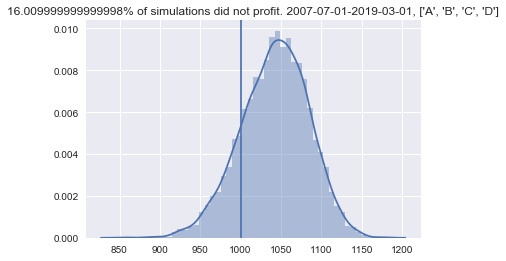

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
import seaborn as sns
from tqdm import tnrange

def simulate(n=10000, grades=['A','B','C','D'], 
             start_date='2007-07-01', 
             end_date='2019-03-01'):
    """
    What if you picked 40 random loans for $25 investments?
    How much would you have been paid back?
    
    Repeat the simulation many times, and plot the distribution 
    of probable outcomes.
    
    This doesn't consider fees or "time value of money."
    """
    
    condition = ((history['grade'].isin(grades)) & 
                 (history['issue_d'] >= start_date) &
                 (history['issue_d'] <= end_date))
    possible = history[condition]
    
    simulations = []
    for _ in tnrange(n):
        picks = possible.sample(40).copy()
        picks['paid'] = 25 * picks['percent_paid']
        paid = picks['paid'].sum()
        simulations.append(paid)
        
    simulations = pd.Series(simulations)
    sns.distplot(simulations)
    plt.axvline(x=1000)
    percent = percentileofscore(simulations, 1000)
    plt.title(f'{percent}% of simulations did not profit. {start_date}-{end_date}, {grades}')

simulate()

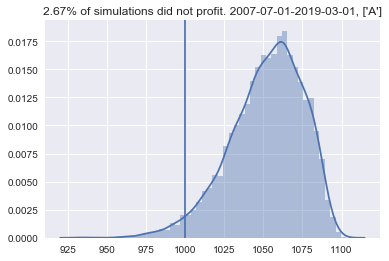

In [21]:
simulate(grades=['A'])

In [22]:
history['earliest_cr_line'] = pd.to_datetime(history['earliest_cr_line'], infer_datetime_format=True)
history['earliest_cr_line'] = history['issue_d'] - history['earliest_cr_line']
history['earliest_cr_line'] = history['earliest_cr_line'].dt.days

current['earliest_cr_line'] = pd.to_datetime(current['earliest_cr_line'], infer_datetime_format=True)
current['earliest_cr_line'] = pd.Timestamp.today() - current['earliest_cr_line']
current['earliest_cr_line'] = current['earliest_cr_line'].dt.days

In [23]:
common_columns = set(history.columns) & set(current.columns)
just_history = set(history.columns) - set(current.columns)
just_current = set(current.columns) - set(history.columns)

In [24]:
features = list(common_columns)
target = 'loan_status'
X = history[features]
y = history[target]

In [25]:
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=20000, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=20000, 
    stratify=y_trainval, random_state=42)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (88334, 106)
y_train shape (88334,)
X_val shape (20000, 106)
y_val shape (20000,)
X_test shape (20000, 106)
y_test shape (20000,)


In [26]:
y_train.value_counts(normalize=True)

Fully Paid     0.824858
Charged Off    0.175142
Name: loan_status, dtype: float64

In [27]:
import numpy as np
from sklearn.metrics import accuracy_score
majority_class = y_train.mode()[0]
y_pred = np.full_like(y_val, fill_value=majority_class)
accuracy_score(y_val, y_pred)

0.82484999999999997

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

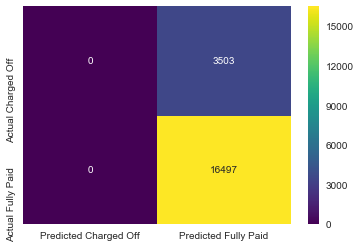

In [29]:
plot_confusion_matrix(y_val, y_pred);

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

             precision    recall  f1-score   support

Charged Off       0.00      0.00      0.00      3503
 Fully Paid       0.82      1.00      0.90     16497

avg / total       0.68      0.82      0.75     20000



/Applications/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
from sklearn.metrics import roc_auc_score

In [32]:
y_pred_proba = np.full_like(y_val, fill_value=1.00)
roc_auc_score(y_val, y_pred_proba)

ValueError: Data is not binary and pos_label is not specified

In [33]:
y_pred_proba = np.full_like(y_val, fill_value=0)
roc_auc_score(y_val, y_pred_proba)

ValueError: Data is not binary and pos_label is not specified

In [34]:
null_counts = X_train.isnull().sum().sort_values(ascending=False)
null_counts.reset_index()

,index,0
0,member_id,88334
1,sec_app_mths_since_last_major_derog,87855
2,sec_app_revol_util,86968
3,sec_app_num_rev_accts,86954
4,revol_bal_joint,86954
5,sec_app_fico_range_low,86954
6,sec_app_inq_last_6mths,86954
7,sec_app_earliest_cr_line,86954
8,sec_app_open_acc,86954
9,sec_app_collections_12_mths_ex_med,86954


In [35]:
%%time

def wrangle(X):
    X = X.copy()

    # Convert percentages from strings to floats
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
        
    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)

    # Transform features with many nulls to binary flags
    many_nulls = ['member_id', 'sec_app_mths_since_last_major_derog', 'sec_app_revol_util', 
                  'sec_app_open_act_il', 'sec_app_chargeoff_within_12_mths', 'sec_app_mort_acc', 
                  'sec_app_fico_range_high', 'revol_bal_joint', 'sec_app_collections_12_mths_ex_med', 
                  'sec_app_inq_last_6mths', 'sec_app_num_rev_accts', 'sec_app_open_acc', 
                  'sec_app_earliest_cr_line', 'sec_app_fico_range_low', 'annual_inc_joint', 
                  'dti_joint', 'desc', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 
                  'mths_since_last_major_derog', 'mths_since_recent_revol_delinq', 'il_util', 
                  'mths_since_rcnt_il', 'all_util', 'open_il_12m', 'total_bal_il', 'open_il_24m', 
                  'inq_last_12m', 'open_rv_12m', 'max_bal_bc', 'open_act_il', 'open_rv_24m', 'inq_fi', 
                  'open_acc_6m', 'total_cu_tl', 'mths_since_last_delinq', 'mths_since_recent_inq', 
                  'num_tl_120dpd_2m', 'mo_sin_old_il_acct', 'emp_title', 'emp_length', 'pct_tl_nvr_dlq', 
                  'avg_cur_bal', 'mo_sin_rcnt_rev_tl_op', 'num_actv_bc_tl', 'num_il_tl', 
                  'mo_sin_rcnt_tl', 'total_rev_hi_lim', 'tot_cur_bal', 'num_bc_tl', 'num_tl_30dpd', 
                  'num_op_rev_tl', 'mo_sin_old_rev_tl_op', 'total_il_high_credit_limit', 
                  'num_rev_tl_bal_gt_0', 'num_accts_ever_120_pd', 'num_tl_90g_dpd_24m', 
                  'num_tl_op_past_12m', 'num_rev_accts', 'tot_hi_cred_lim', 'tot_coll_amt', 
                  'num_actv_rev_tl', 'bc_util', 'percent_bc_gt_75', 'bc_open_to_buy', 
                  'mths_since_recent_bc', 'num_bc_sats', 'num_sats', 'total_bc_limit', 
                  'acc_open_past_24mths', 'total_bal_ex_mort', 'mort_acc', 'title']
    
    for col in many_nulls:
        X[col] = X[col].isnull()
    
    # For features with few nulls, do mean imputation
    for col in X:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].mean())
            
    # Drop some columns
    X = X.drop(columns='id')  # id is random
    X = X.drop(columns='member_id')  # member_id is always null
    X = X.drop(columns='title')  # Duplicative of purpose
    X = X.drop(columns='grade')  # Duplicative of sub_grade
    X = X.drop(columns='zip_code') # High cardinality

    # Transform sub_grade from "A1" - "G5" to 1.1 - 7.5
    def wrangle_sub_grade(x):
        first_digit = ord(x[0]) - 64
        second_digit = int(x[1])
        return first_digit + second_digit/10
    
    X['sub_grade'] = X['sub_grade'].apply(wrangle_sub_grade)
    
    # Return the wrangled dataframe
    return X


X_train = wrangle(X_train)
X_val   = wrangle(X_val)
X_test  = wrangle(X_test)

CPU times: user 2.69 s, sys: 1.11 s, total: 3.8 s
Wall time: 4.03 s


In [2]:
%%time
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)

pipeline.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [ ]:
y_pred = pipeline.predict(X_val)
accuracy_score(y_val, y_pred)

In [ ]:
plot_confusion_matrix(y_val, y_pred);

In [ ]:
print(classification_report(y_val, y_pred))

In [ ]:
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_proba)

In [ ]:
from ipywidgets import interact, fixed
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels

def set_threshold(y_true, y_pred_proba, threshold=0.5):
    """
    For binary classification problems. 
    y_pred_proba : predicted probability of class 1
    """
    
    # Apply threshold to predicted probabilities
    # to get discrete predictions
    class_0, class_1 = unique_labels(y_true)
    y_pred = np.full_like(y_true, fill_value=class_0)
    y_pred[y_pred_proba > threshold] = class_1
    
    # Plot distribution of predicted probabilities
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.title('Distribution of predicted probabilities')
    plt.show()

    # Calculate true positive rate and false positive rate
    true_positives = (y_pred==y_true) & (y_pred==class_1)
    false_positives = (y_pred!=y_true) & (y_pred==class_1)
    actual_positives = (y_true==class_1)
    actual_negatives = (y_true==class_0)
    true_positive_rate = true_positives.sum() / actual_positives.sum()
    false_positive_rate = false_positives.sum() / actual_negatives.sum()
    print('False Positive Rate', false_positive_rate)
    print('True Positive Rate', true_positive_rate)
    
    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_true==class_1, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Plot point on ROC curve for the current threshold
    plt.scatter(false_positive_rate, true_positive_rate)
    plt.show()
    
    # Show ROC AUC score
    print('Area under the Receiver Operating Characteristic curve:', 
          roc_auc_score(y_true, y_pred_proba))
    
    # Show confusion matrix & classification report
    plot_confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred))

interact(set_threshold, 
         y_true=fixed(y_val), 
         y_pred_proba=fixed(y_pred_proba), 
         threshold=(0,1,0.05));

In [ ]:
from sklearn.model_selection import train_test_split

def train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, 
    random_state=None, shuffle=True):
        
    assert train_size + val_size + test_size == 1
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(train_size+val_size), 
        random_state=random_state, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
%matplotlib inline
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions


#1. Generate data

# Try re-running the cell with different values for these parameters
n_samples = 1000
weights = (0.95, 0.05)
class_sep = 0.8

X, y = make_classification(n_samples=n_samples, n_features=2, n_informative=2, 
                           n_redundant=0, n_repeated=0, n_classes=2, 
                           n_clusters_per_class=1, weights=weights, 
                           class_sep=class_sep, random_state=0)


# 2. Split data

# Uses our custom train_validation_test_split function
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=1)


# 3. Fit model

# Try re-running the cell with different values for this parameter
class_weight = 'balanced'

model = LogisticRegression(solver='lbfgs', class_weight=class_weight)
model.fit(X_train, y_train)


# 4. Evaluate model

y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
plot_confusion_matrix(y_val, y_pred)

# 5. Visualize decision regions

plt.figure(figsize=(10, 6))
plot_decision_regions(X_val, y_val, model, legend=0);